# Imports


In [ ]:
import numpy as np
import _pickle as cPickle
import keras
from keras import metrics
import sys 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import scipy as sp
from scipy.integrate import cumtrapz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework import ops
import gc

#Loading the data 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = "/content/drive/My Drive/pattern/RML2016.10b.dat"
open_file = open(filename,'rb')
data = cPickle.load(open_file, encoding='latin1')

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])

X = []
labels_categorical = []
for mod in mods:
    for snr in snrs:
        X.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  labels_categorical.append((mod,snr))
X = np.vstack(X)


print(X.shape)
del data

(1200000, 2, 128)


In [ ]:
# '8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64' 'QPSK' 'WBFM' 
LABELS = {'8PSK' :   np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
          'AM-DSB' : np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
          'AM-SSB' : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
          'BPSK' :   np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
          'CPFSK' :  np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
          'GFSK' :   np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
          'PAM4' :   np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
          'QAM16' :  np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
          'QAM64' :  np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
          'QPSK' :   np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
          'WBFM' :   np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
        }

In [ ]:
labels = np.array([LABELS[letter] for letter in [ seq[0] for seq in labels_categorical ]])
print(labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [ ]:
all_labels = np.array([(LABELS[mod],snr) for mod, snr in labels_categorical])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
all_labels.shape
print(all_labels)

[[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) -20]
 [array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) -20]
 [array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) -20]
 ...
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) 18]
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) 18]
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) 18]]


# **Extracting Features**

Row Features

First Derivative

In [ ]:
X_derivative = np.gradient(X, axis=-1)
X_derivative.shape

(1200000, 2, 128)

Integral In Time

In [ ]:
X_integral = cumtrapz(X, axis=-1, initial=0)
X_integral.shape

(1200000, 2, 128)

# Combined 

In [ ]:
X_derivative = X_derivative[:, :, :, np.newaxis]

In [ ]:
X_integral = X_integral[:, :, :, np.newaxis]

In [ ]:
X = X[:, :, :, np.newaxis]

Raw Derivative

In [ ]:
# X_raw_derv = []
# for x, x_derv in zip(X, X_derivative):
#   X_raw_derv.append(np.concatenate((x, x_derv), axis=0))
X_raw_derv =np.concatenate((X, X_derivative),axis=1)
X_raw_derv.shape

(1200000, 4, 128, 1)

Raw Integral

In [ ]:
# X_raw_integ = []
# for x, x_int in zip(X, X_integral):
#   X_raw_derv.append(np.concatenate((x, x_int), axis=0))
X_raw_integ =np.concatenate((X, X_integral),axis=1)
X_raw_integ.shape

(1200000, 4, 128, 1)

Raw Derivative Integral

In [ ]:
# X_combined = []
# for x_row_drev, x_int in zip(X_raw_derv, X_integral):
#   X_combined.append(np.concatenate((x_row_drev, x_int), axis=0))
X_combined =np.concatenate((X_raw_derv, X_integral),axis=1)
X_combined.shape

(1200000, 6, 128, 1)

**deleting**

In [ ]:
del X

In [ ]:
del X_derivative

In [ ]:
del X_integral

In [ ]:
del X_raw_derv

In [ ]:
del X_raw_integ

In [ ]:
gc.collect()

651

# **Data Splitting**

In [ ]:
def split_data(X, labels):
  X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3, random_state=0)
  del X
  del labels
  X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05, random_state=0)
  # del X_train_val
  # del Y_train_val
  return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
# Raw data only
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, all_labels)
Y_train = np.array([val for val in Y_train[:,0]])
Y_val = np.array([val for val in Y_val[:,0]])
Y_test_snr = np.array([val for val in Y_test[:,1]])
Y_test = np.array([val for val in Y_test[:,0]])
print(X_train.shape)

X_tuning, X_val_tuning, Y_tuning, Y_val_tuning = train_test_split(X_train, Y_train, test_size=0.5, random_state=0)

(798000, 2, 128)


In [ ]:
# Derivative data only
X_deriv_train, Y_deriv_train, X_deriv_val, Y_deriv_val, X_deriv_test, Y_deriv_test = split_data(X_derivative, all_labels)
Y_deriv_train = np.array([val for val in Y_deriv_train[:,0]])
Y_deriv_val = np.array([val for val in Y_deriv_val[:,0]])
Y_deriv_test_snr = np.array([val for val in Y_deriv_test[:,1]])
Y_deriv_test = np.array([val for val in Y_deriv_test[:,0]])


X_drev_tuning, X_drev_val_tuning, Y_drev_tuning, Y_drev_val_tuning = train_test_split(X_deriv_train, Y_deriv_train, test_size=0.5, random_state=0)

In [ ]:
# Integral data only
X_int_train, Y_int_train, X_int_val, Y_int_val, X_int_test, Y_int_test = split_data(X_integral, all_labels)
Y_int_train = np.array([val for val in Y_int_train[:,0]])
Y_int_val = np.array([val for val in Y_int_val[:,0]])
Y_int_test_snr = np.array([val for val in Y_int_test[:,1]])
Y_int_test = np.array([val for val in Y_int_test[:,0]])


X_int_tuning, X_int_val_tuning, Y_int_tuning, Y_int_val_tuning = train_test_split(X_int_train, Y_int_train, test_size=0.5, random_state=0)

In [ ]:
# Raw and Derivative
X_raw_deriv_train, Y_raw_deriv_train, X_raw_deriv_val, Y_raw_deriv_val, X_raw_deriv_test, Y_raw_deriv_test = split_data(X_raw_derv, all_labels)
Y_raw_deriv_train = np.array([val for val in Y_raw_deriv_train[:,0]])
Y_raw_deriv_val = np.array([val for val in Y_raw_deriv_val[:,0]])
Y_raw_deriv_test_snr = np.array([val for val in Y_raw_deriv_test[:,1]])
Y_raw_deriv_test = np.array([val for val in Y_raw_deriv_test[:,0]])


X_raw_deriv_tuning, X_raw_deriv_val_tuning, Y_raw_deriv_tuning, Y_raw_deriv_val_tuning = train_test_split(X_raw_deriv_train, Y_raw_deriv_train, test_size=0.5, random_state=0)

In [ ]:
# Raw and Integral
X_raw_int_train, Y_raw_int_train, X_raw_int_val, Y_raw_int_val, X_raw_int_test, Y_raw_int_test = split_data(X_raw_integ, all_labels)
Y_raw_int_train = np.array([val for val in Y_raw_int_train[:,0]])
Y_raw_int_val = np.array([val for val in Y_raw_int_val[:,0]])
Y_raw_int_test_snr = np.array([val for val in Y_raw_int_test[:,1]])
Y_raw_int_test = np.array([val for val in Y_raw_int_test[:,0]])


X_raw_int_tuning, X_raw_int_val_tuning, Y_raw_int_tuning, Y_raw_int_val_tuning = train_test_split(X_raw_int_train, Y_raw_int_train, test_size=0.5, random_state=0)

In [ ]:
# Raw, derivative, and integral
X_combined_train, Y_combined_train, X_combined_val, Y_combined_val, X_combined_test, Y_combined_test = split_data(X_combined, all_labels)
Y_combined_train = np.array([val for val in Y_combined_train[:,0]])
Y_combined_val = np.array([val for val in Y_combined_val[:,0]])
Y_combined_test_snr = np.array([val for val in Y_combined_test[:,1]])
Y_combined_test = np.array([val for val in Y_combined_test[:,0]])


X_combined_tuning, X_combined_val_tuning, Y_combined_tuning, Y_combined_val_tuning = train_test_split(X_combined_train, Y_combined_train, test_size=0.5, random_state=0)

# **Model**

# **CNN**

In [ ]:
def create_cnn_model(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  Z0 = tfl.Conv2D(64, (1, 3), activation='relu', padding="same", strides=1)(input_img)
  Z1 = tfl.Conv2D(16, (2, 3), activation='relu', padding="same", strides=1)(Z0)
  F = tfl.Flatten()(Z1)
  FC1 = tfl.Dense(128, activation='relu')(F)
  outputs = tfl.Dense(11, activation='softmax')(FC1)
  # YOUR CODE ENDS HERE
  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

Tuning

In [ ]:
def get_best_learning_rate(input_shape, x, y, x_val, y_val, x_test, y_test):
  learning_rates = [0.1, 0.01, 0.001, 0.0001]
  best_acc = 0
  best_learning_rate = 0
  for lr in learning_rates:
    cnn = create_cnn_model(input_shape)
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    cnn.compile(optimizer=adam,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    cnn.summary()
    print("\nlearning rate : ", lr)
    history = cnn.fit(x, y, batch_size=1024, epochs=20, verbose=2, validation_data=(x_val, y_val)) 
    evaluation = cnn.evaluate(x_test, y_test, batch_size=1024)

    # Show loss curves 
    plt.figure()
    plt.title('Training performance learning rate ' + str(lr))
    plt.plot(history.epoch, history.history['loss'], label='train loss+error')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.legend()

    accuracy = evaluation[1]
    if accuracy > best_acc:
      best_acc = accuracy
      best_learning_rate = lr
  return best_learning_rate

### Raw data run

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainable

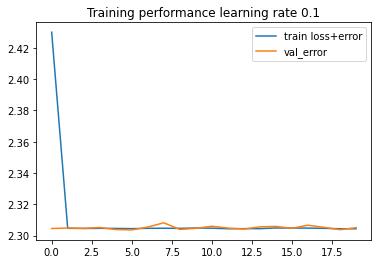

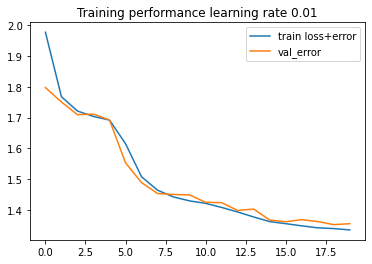

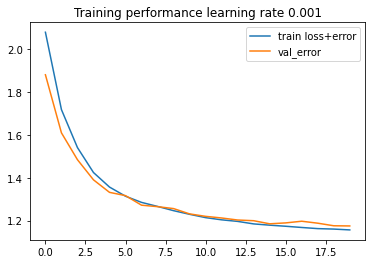

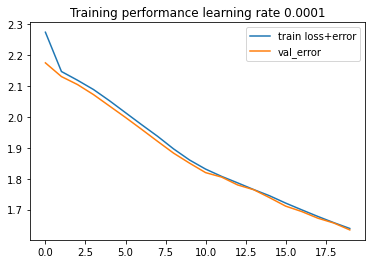

In [ ]:
best_rate_raw = get_best_learning_rate((2, 128, 1), X_tuning, Y_tuning, X_val_tuning, Y_val_tuning, X_val, Y_val)

In [ ]:
print(best_rate_raw)

0.001


In [ ]:
cnn_model = create_cnn_model((2, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_raw)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainable

In [ ]:
history = cnn_model.fit(X_train, Y_train, batch_size=1024, epochs=100, verbose=2, validation_data=(X_val, Y_val)) 

Epoch 1/100
780/780 - 18s - loss: 1.8602 - accuracy: 0.2735 - val_loss: 1.5072 - val_accuracy: 0.3922 - 18s/epoch - 23ms/step
Epoch 2/100
780/780 - 18s - loss: 1.3849 - accuracy: 0.4415 - val_loss: 1.3181 - val_accuracy: 0.4665 - 18s/epoch - 23ms/step
Epoch 3/100
780/780 - 17s - loss: 1.2923 - accuracy: 0.4745 - val_loss: 1.2914 - val_accuracy: 0.4763 - 17s/epoch - 22ms/step
Epoch 4/100
780/780 - 18s - loss: 1.2580 - accuracy: 0.4871 - val_loss: 1.2452 - val_accuracy: 0.4881 - 18s/epoch - 23ms/step
Epoch 5/100
780/780 - 18s - loss: 1.2239 - accuracy: 0.4994 - val_loss: 1.2118 - val_accuracy: 0.5002 - 18s/epoch - 23ms/step
Epoch 6/100
780/780 - 18s - loss: 1.1949 - accuracy: 0.5103 - val_loss: 1.1855 - val_accuracy: 0.5108 - 18s/epoch - 23ms/step
Epoch 7/100
780/780 - 18s - loss: 1.1686 - accuracy: 0.5197 - val_loss: 1.1570 - val_accuracy: 0.5211 - 18s/epoch - 23ms/step
Epoch 8/100
780/780 - 18s - loss: 1.1424 - accuracy: 0.5290 - val_loss: 1.1370 - val_accuracy: 0.5341 - 18s/epoch - 23

In [ ]:
cnn_model.evaluate(X_test, Y_test, batch_size=1024)

352/352 [==============================] - 3s 9ms/step - loss: 1.1495 - accuracy: 0.5633


[1.149524450302124, 0.5632916688919067]

### Derivative data run

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainable

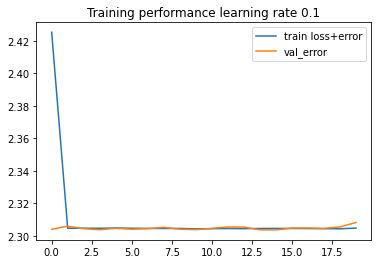

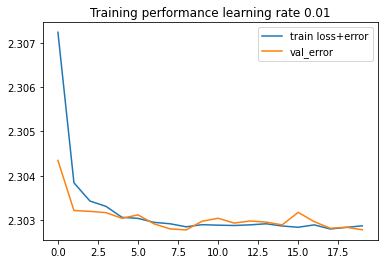

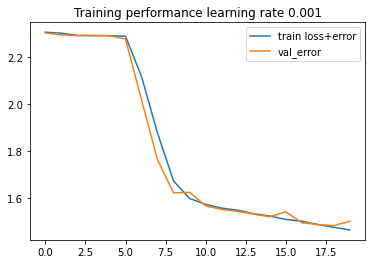

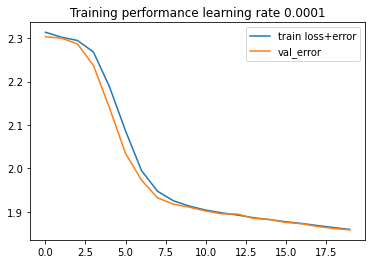

In [ ]:
best_rate_deriv = get_best_learning_rate((2, 128, 1), X_drev_tuning, Y_drev_tuning, X_drev_val_tuning, Y_drev_val_tuning, X_deriv_val, Y_deriv_val)

In [ ]:
cnn_model = create_cnn_model((2, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_deriv)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 128, 64)        256       
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               524416    
                                                                 
 dense_9 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainab

In [ ]:
history = cnn_model.fit(X_deriv_train, Y_deriv_train, batch_size=1024, epochs=20, verbose=2, validation_data=(X_deriv_val, Y_deriv_val)) 

Epoch 1/20
780/780 - 19s - loss: 2.3031 - accuracy: 0.1023 - val_loss: 2.2989 - val_accuracy: 0.1207 - 19s/epoch - 24ms/step
Epoch 2/20
780/780 - 17s - loss: 2.2928 - accuracy: 0.1198 - val_loss: 2.2920 - val_accuracy: 0.1193 - 17s/epoch - 22ms/step
Epoch 3/20
780/780 - 17s - loss: 2.1963 - accuracy: 0.1575 - val_loss: 1.9219 - val_accuracy: 0.2710 - 17s/epoch - 22ms/step
Epoch 4/20
780/780 - 18s - loss: 1.8565 - accuracy: 0.2821 - val_loss: 1.7871 - val_accuracy: 0.2955 - 18s/epoch - 23ms/step
Epoch 5/20
780/780 - 17s - loss: 1.7385 - accuracy: 0.3080 - val_loss: 1.6849 - val_accuracy: 0.3235 - 17s/epoch - 22ms/step
Epoch 6/20
780/780 - 18s - loss: 1.6513 - accuracy: 0.3268 - val_loss: 1.6177 - val_accuracy: 0.3305 - 18s/epoch - 23ms/step
Epoch 7/20
780/780 - 18s - loss: 1.5971 - accuracy: 0.3384 - val_loss: 1.5851 - val_accuracy: 0.3364 - 18s/epoch - 23ms/step
Epoch 8/20
780/780 - 18s - loss: 1.5675 - accuracy: 0.3461 - val_loss: 1.5574 - val_accuracy: 0.3468 - 18s/epoch - 23ms/step


In [ ]:
cnn_model.evaluate(X_deriv_test, Y_deriv_test, batch_size=1024)

352/352 [==============================] - 3s 9ms/step - loss: 1.4195 - accuracy: 0.4064


[1.4194697141647339, 0.40637779235839844]

### Integral data run 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainable

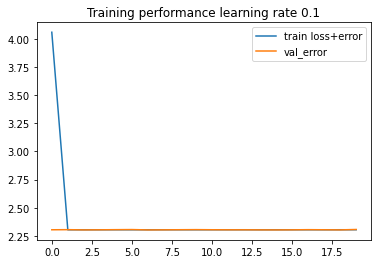

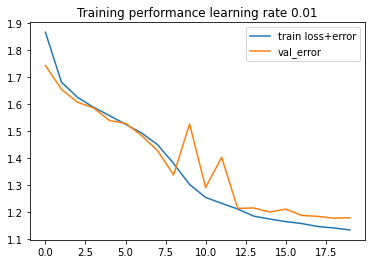

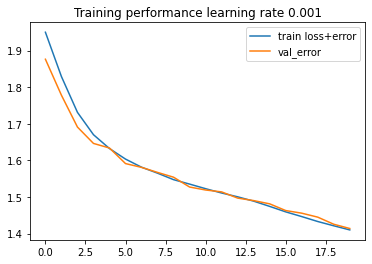

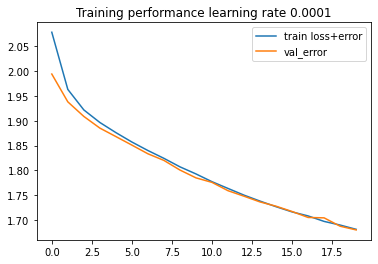

In [ ]:
best_rate_int = get_best_learning_rate((2, 128, 1), X_int_tuning, Y_int_tuning, X_int_val_tuning, Y_int_val_tuning, X_int_val, Y_int_val)

In [ ]:
cnn_model = create_cnn_model((2, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_int)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 128, 64)        256       
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               524416    
                                                                 
 dense_9 (Dense)             (None, 11)                1419      
                                                                 
Total params: 532,251
Trainable params: 532,251
Non-trainab

In [ ]:
print(best_rate_int)

0.01


In [ ]:
history = cnn_model.fit(X_int_train, Y_int_train, batch_size=1024, epochs=20, verbose=2, validation_data=(X_int_val, Y_int_val)) 

Epoch 1/20
780/780 - 18s - loss: 1.4022 - accuracy: 0.4258 - val_loss: 1.3372 - val_accuracy: 0.4490 - 18s/epoch - 23ms/step
Epoch 2/20
780/780 - 18s - loss: 1.3153 - accuracy: 0.4551 - val_loss: 1.2944 - val_accuracy: 0.4630 - 18s/epoch - 23ms/step
Epoch 3/20
780/780 - 18s - loss: 1.4089 - accuracy: 0.4198 - val_loss: 1.3657 - val_accuracy: 0.4354 - 18s/epoch - 24ms/step
Epoch 4/20
780/780 - 18s - loss: 1.3058 - accuracy: 0.4570 - val_loss: 1.2660 - val_accuracy: 0.4710 - 18s/epoch - 24ms/step
Epoch 5/20
780/780 - 17s - loss: 1.2490 - accuracy: 0.4776 - val_loss: 1.2254 - val_accuracy: 0.4831 - 17s/epoch - 22ms/step
Epoch 6/20
780/780 - 18s - loss: 1.2173 - accuracy: 0.4898 - val_loss: 1.2020 - val_accuracy: 0.4939 - 18s/epoch - 23ms/step
Epoch 7/20
780/780 - 18s - loss: 1.1914 - accuracy: 0.4994 - val_loss: 1.1945 - val_accuracy: 0.5008 - 18s/epoch - 23ms/step
Epoch 8/20
780/780 - 18s - loss: 1.1761 - accuracy: 0.5051 - val_loss: 1.1735 - val_accuracy: 0.5036 - 18s/epoch - 22ms/step


In [ ]:
cnn_model.evaluate(X_int_test, Y_int_test, batch_size=1024)

352/352 [==============================] - 3s 9ms/step - loss: 1.1196 - accuracy: 0.5303


[1.1195783615112305, 0.5302583575248718]

### Raw and Derivative data run

In [ ]:
best_rate_raw_deriv = get_best_learning_rate((4, 128, 1), X_raw_deriv_tuning, Y_raw_deriv_tuning, X_raw_deriv_val_tuning, Y_raw_deriv_val_tuning, X_raw_deriv_val, Y_raw_deriv_val)

In [ ]:
cnn_model = create_cnn_model((4, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_raw_deriv)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 4, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 1,056,539
Trainable params: 1,056,539
Non-train

In [ ]:
history = cnn_model.fit(X_raw_deriv_train, Y_raw_deriv_train, batch_size=1024, epochs=20, verbose=2, validation_data=(X_raw_deriv_val, Y_raw_deriv_val)) 

Epoch 1/20
780/780 - 46s - loss: 1.8821 - accuracy: 0.2712 - val_loss: 1.5762 - val_accuracy: 0.3730 - 46s/epoch - 59ms/step
Epoch 2/20
780/780 - 34s - loss: 1.4353 - accuracy: 0.4264 - val_loss: 1.3430 - val_accuracy: 0.4565 - 34s/epoch - 43ms/step
Epoch 3/20
780/780 - 35s - loss: 1.3125 - accuracy: 0.4651 - val_loss: 1.3057 - val_accuracy: 0.4582 - 35s/epoch - 45ms/step
Epoch 4/20
780/780 - 35s - loss: 1.2653 - accuracy: 0.4804 - val_loss: 1.2478 - val_accuracy: 0.4791 - 35s/epoch - 44ms/step
Epoch 5/20
780/780 - 35s - loss: 1.2196 - accuracy: 0.4952 - val_loss: 1.2001 - val_accuracy: 0.5018 - 35s/epoch - 44ms/step
Epoch 6/20
780/780 - 35s - loss: 1.1869 - accuracy: 0.5048 - val_loss: 1.1817 - val_accuracy: 0.4981 - 35s/epoch - 45ms/step
Epoch 7/20
780/780 - 35s - loss: 1.1672 - accuracy: 0.5110 - val_loss: 1.1678 - val_accuracy: 0.5050 - 35s/epoch - 44ms/step
Epoch 8/20
780/780 - 35s - loss: 1.1542 - accuracy: 0.5149 - val_loss: 1.1546 - val_accuracy: 0.5112 - 35s/epoch - 44ms/step


In [ ]:
cnn_model.evaluate(X_raw_deriv_test, Y_raw_deriv_test, batch_size=1024)

352/352 [==============================] - 6s 16ms/step - loss: 1.0906 - accuracy: 0.5439


[1.090637445449829, 0.5438694357872009]

### Raw and Integral data run

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 4, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 1,056,539
Trainable params: 1,056,539
Non-train

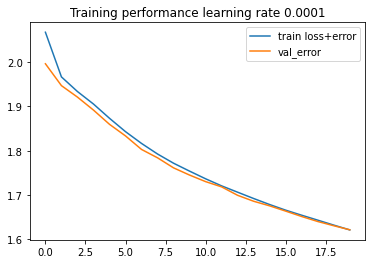

In [ ]:
best_rate_raw_int = get_best_learning_rate((4, 128, 1), X_raw_int_tuning, Y_raw_int_tuning, X_raw_int_val_tuning, Y_raw_int_val_tuning, X_raw_int_val, Y_raw_int_val)

In [ ]:
cnn_model = create_cnn_model((4, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_raw_int)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 4, 128, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 128, 16)        6160      
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 11)                1419      
                                                                 
Total params: 1,056,539
Trainable params: 1,056,539
Non-train

In [ ]:
history = cnn_model.fit(X_raw_int_train, Y_raw_int_train, batch_size=1024, epochs=20, verbose=2, validation_data=(X_raw_int_val, Y_raw_int_val)) 

Epoch 1/20
780/780 - 47s - loss: 1.8799 - accuracy: 0.2601 - val_loss: 1.7282 - val_accuracy: 0.3141 - 47s/epoch - 60ms/step
Epoch 2/20
780/780 - 34s - loss: 1.5600 - accuracy: 0.3774 - val_loss: 1.4586 - val_accuracy: 0.4117 - 34s/epoch - 43ms/step
Epoch 3/20
780/780 - 33s - loss: 1.3620 - accuracy: 0.4465 - val_loss: 1.3126 - val_accuracy: 0.4519 - 33s/epoch - 42ms/step
Epoch 4/20
780/780 - 33s - loss: 1.2914 - accuracy: 0.4670 - val_loss: 1.2592 - val_accuracy: 0.4706 - 33s/epoch - 43ms/step
Epoch 5/20
780/780 - 33s - loss: 1.2592 - accuracy: 0.4760 - val_loss: 1.2463 - val_accuracy: 0.4724 - 33s/epoch - 43ms/step
Epoch 6/20
780/780 - 33s - loss: 1.2362 - accuracy: 0.4837 - val_loss: 1.2329 - val_accuracy: 0.4790 - 33s/epoch - 43ms/step
Epoch 7/20
780/780 - 33s - loss: 1.2194 - accuracy: 0.4901 - val_loss: 1.2602 - val_accuracy: 0.4694 - 33s/epoch - 43ms/step
Epoch 8/20
780/780 - 33s - loss: 1.2036 - accuracy: 0.4954 - val_loss: 1.1945 - val_accuracy: 0.4982 - 33s/epoch - 43ms/step


In [ ]:
cnn_model.evaluate(X_raw_int_test, Y_raw_int_test, batch_size=1024)

352/352 [==============================] - 6s 16ms/step - loss: 1.1101 - accuracy: 0.5361


[1.1100636720657349, 0.5361083149909973]

### Combined Data run

In [ ]:
best_rate_combined = get_best_learning_rate((6, 128, 1), X_combined_tuning, Y_combined_tuning, X_combined_val_tuning, Y_combined_val_tuning, X_combined_val, Y_combined_val)

In [ ]:
cnn_model = create_cnn_model((6, 128, 1))
adam = tf.keras.optimizers.Adam(learning_rate=best_rate_combined)
cnn_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

In [ ]:
history = cnn_model.fit(X_combined_train, Y_combined_train, batch_size=1024, epochs=10, verbose=2, validation_data=(X_combined_val, Y_combined_val)) 

In [ ]:
cnn_model.evaluate(X_combined_test, Y_combined_test, batch_size=1024)

# **CNN 1D**

In [ ]:
def create_cnn1D_model(input_shape):
  model = Sequential()
  model.add(tfl.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', input_shape=input_shape, data_format='channels_first'))
  model.add(tfl.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'))
  model.add(tfl.Flatten())
  model.add(tfl.Dense(128, activation='relu'))
  model.add(tfl.Dense(11, activation='softmax'))
  # YOUR CODE ENDS HERE
  # adam = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
cnn_1d_model = create_cnn1D_model((2,128))

In [ ]:
history = cnn_1d_model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=2, validation_data=(X_val, Y_val)) 

Epoch 1/50
780/780 - 20s - loss: 1.9619 - accuracy: 0.2304 - val_loss: 1.7036 - val_accuracy: 0.3010 - 20s/epoch - 26ms/step
Epoch 2/50
780/780 - 6s - loss: 1.5412 - accuracy: 0.3829 - val_loss: 1.4321 - val_accuracy: 0.4282 - 6s/epoch - 7ms/step
Epoch 3/50
780/780 - 6s - loss: 1.3832 - accuracy: 0.4459 - val_loss: 1.3668 - val_accuracy: 0.4523 - 6s/epoch - 7ms/step
Epoch 4/50
780/780 - 6s - loss: 1.3318 - accuracy: 0.4649 - val_loss: 1.3357 - val_accuracy: 0.4685 - 6s/epoch - 8ms/step
Epoch 5/50
780/780 - 6s - loss: 1.2908 - accuracy: 0.4792 - val_loss: 1.2975 - val_accuracy: 0.4792 - 6s/epoch - 7ms/step
Epoch 6/50
780/780 - 6s - loss: 1.2677 - accuracy: 0.4845 - val_loss: 1.2609 - val_accuracy: 0.4865 - 6s/epoch - 7ms/step
Epoch 7/50
780/780 - 6s - loss: 1.2481 - accuracy: 0.4884 - val_loss: 1.2427 - val_accuracy: 0.4906 - 6s/epoch - 8ms/step
Epoch 8/50
780/780 - 6s - loss: 1.2301 - accuracy: 0.4931 - val_loss: 1.2167 - val_accuracy: 0.4884 - 6s/epoch - 7ms/step
Epoch 9/50
780/780 - 

In [ ]:
cnn_1d_model.evaluate(X_test, Y_test, batch_size=1024)

352/352 [==============================] - 2s 5ms/step - loss: 1.0456 - accuracy: 0.5612


[1.045606017112732, 0.5612221956253052]

Big picture

  Accuracy =  0.1019525183048591
  Accuracy =  0.11257612157103748
  Accuracy =  0.12070222670929384
  Accuracy =  0.14881184261784183
  Accuracy =  0.213617207596738
  Accuracy =  0.2856983551714525
  Accuracy =  0.35849678589088513
  Accuracy =  0.45652053427922185
  Accuracy =  0.5828374395194929
  Accuracy =  0.6982434821034026
  Accuracy =  0.773191324982065
  Accuracy =  0.8106984478935698
  Accuracy =  0.8168541212019473
  Accuracy =  0.8192294844672086
  Accuracy =  0.8219909854766012
  Accuracy =  0.8225450127029714
  Accuracy =  0.8198768103878808
  Accuracy =  0.8205841446453408
  Accuracy =  0.8249231628946633
  Accuracy =  0.8184272696591293


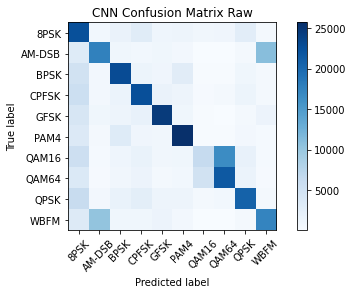

In [ ]:
y_pred = cnn_1d_model.predict(X_test)
test_Y_all = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Raw")

acc = []
for snr in snrs:
    test_X_i = X_test[np.where(Y_test_snr == snr)]
    test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
    y_pred = cnn_1d_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)  

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

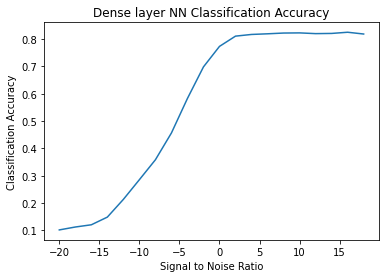

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

SNR =  0
  Accuracy =  0.773191324982065


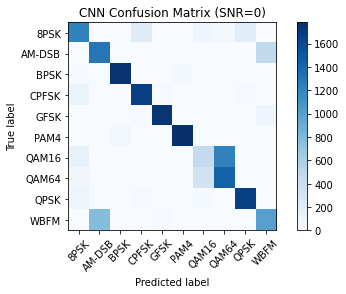

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_test[np.where(Y_test_snr == snr)]
test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
y_pred = cnn_1d_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

# **RNN**

In [ ]:
def get_best_learning_rate_rnn(input_shape, x, y, x_val, y_val, x_test, y_test):
  learning_rates = [0.1, 0.01, 0.001, 0.0001]
  best_acc = 0
  best_learning_rate = 0
  for lr in learning_rates:
    rnn = get_vanilla_rnn(input_shape, lr)
    print("\nlearning rate : ", lr)
    history = rnn.fit(x, y, batch_size=1024, epochs=20, verbose=2, validation_data=(x_val, y_val)) 
    evaluation = rnn.evaluate(x_test, y_test, batch_size=1024)
    
    # Show loss curves 
    plt.figure()
    plt.title('Training performance learning rate ' + str(lr))
    plt.plot(history.epoch, history.history['loss'], label='train loss+error')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.legend()

    accuracy = evaluation[1]
    if accuracy > best_acc:
      best_acc = accuracy
      best_learning_rate = lr
  return best_learning_rate

In [ ]:
def get_vanilla_rnn(input_shape, lr):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape = input_shape, return_sequences = False))
    model.add(Dense(11))
    model.add(Activation('softmax'))
    adam = tf.keras.optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

Raw data only run

In [ ]:
best_lr_raw = get_best_learning_rate_rnn((2,128), X_tuning, Y_tuning, X_val_tuning, Y_val_tuning, X_val, Y_val)

In [ ]:
rnn = get_vanilla_rnn((2,128), best_lr_raw)
rnn.fit(X_train, Y_train, batch_size=1024, epochs=10, validation_data=(X_val, Y_val))

In [ ]:
rnn.evaluate(X_test, Y_test, batch_size=1024)

Derivative data run

In [ ]:
best_lr_deriv = get_best_learning_rate_rnn((2,128), X_drev_tuning, Y_drev_tuning, X_drev_val_tuning, Y_drev_val_tuning, X_deriv_val, Y_deriv_val)

In [ ]:
rnn = get_vanilla_rnn((2,128), best_lr_deriv)
rnn.fit(X_deriv_train, Y_deriv_train, batch_size=1024, epochs=100, validation_data=(X_deriv_val, Y_deriv_val))

In [ ]:
rnn.evaluate(X_deriv_test, Y_deriv_test, batch_size=1024)

Integral data run

In [ ]:
best_lr_int = get_best_learning_rate_rnn((2,128), X_int_tuning, Y_int_tuning, X_int_val_tuning, Y_int_val_tuning, X_int_val, Y_int_val)

In [ ]:
rnn = get_vanilla_rnn((2,128), best_lr_int)
rnn.fit(X_int_train, Y_int_train, batch_size=1024, epochs=100, validation_data=(X_int_val, Y_int_val))

In [ ]:
rnn.evaluate(X_int_test, Y_int_test, batch_size=1024)

Raw and Derivative data run

In [ ]:
best_lr_raw_deriv = get_best_learning_rate_rnn((4,128), X_raw_deriv_tuning, Y_raw_deriv_tuning, X_raw_deriv_val_tuning, Y_raw_deriv_val_tuning, X_raw_deriv_val, Y_raw_deriv_val)

In [ ]:
rnn = get_vanilla_rnn((4,128), best_lr_raw_deriv)
rnn.fit(X_raw_deriv_train, Y_raw_deriv_train, batch_size=1024, epochs=100, validation_data=(X_raw_deriv_val, Y_raw_deriv_val))

In [ ]:
rnn.evaluate(X_raw_deriv_test, Y_raw_deriv_test, batch_size=1024)

Raw and Integral

In [ ]:
best_lr_raw_int = get_best_learning_rate_rnn((4,128), X_raw_int_tuning, Y_raw_int_tuning, X_raw_int_val_tuning, Y_raw_int_val_tuning, X_raw_int_val, Y_raw_int_val)

In [ ]:
rnn = get_vanilla_rnn((4,128), best_lr_raw_int)
rnn.fit(X_raw_int_train, Y_raw_int_train, batch_size=1024, epochs=100, validation_data=(X_raw_int_val, Y_raw_int_val))

In [ ]:
rnn.evaluate(X_raw_int_test, Y_raw_int_test, batch_size=1024)

All features combined

In [ ]:
best_lr_combined = get_best_learning_rate_rnn((6,128), X_combined_tuning, Y_combined_tuning, X_combined_val_tuning, Y_combined_val_tuning, X_combined_val, Y_combined_val)

In [ ]:
rnn = get_vanilla_rnn((6,128), best_lr_combined)
rnn.fit(X_combined_train, Y_combined_train, batch_size=1024, epochs=100, validation_data=(X_combined_val, Y_combined_val))

In [ ]:
rnn.evaluate(X_combined_test, Y_combined_test, batch_size=1024)

# **LSTM**

In [ ]:
def get_best_learning_rate_lstm(input_shape, x, y, x_val, y_val, x_test, y_test):
  learning_rates = [0.1, 0.01, 0.001, 0.0001]
  best_acc = 0
  best_learning_rate = 0
  for lr in learning_rates:
    lstm = getLSTM(input_shape, lr)
    print("\nlearning rate : ", lr)
    history = lstm.fit(x, y, batch_size=1024, epochs=20, verbose=2, validation_data=(x_val, y_val)) 
    evaluation = lstm.evaluate(x_test, y_test, batch_size=1024)
    
    # Show loss curves 
    plt.figure()
    plt.title('Training performance learning rate ' + str(lr))
    plt.plot(history.epoch, history.history['loss'], label='train loss+error')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.legend()


    accuracy = evaluation[1]
    if accuracy > best_acc:
      best_acc = accuracy
      best_learning_rate = lr
  return best_learning_rate

In [ ]:
def getLSTM(shape, lr):
  lstm = Sequential();
  lstm.add(LSTM(128, return_sequences=True, input_shape=shape))
  lstm.add(LSTM(11))
  lstm.add(Dense(11, activation='softmax'))
  adam = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
  # print(lstm.summary())
  return lstm

Raw data only

In [ ]:
best_lr_raw_lstm = get_best_learning_rate_lstm((2,128), X_tuning, Y_tuning, X_val_tuning, Y_val_tuning, X_val, Y_val)

In [ ]:
lstm = getLSTM((2,128), best_lr_raw_lstm)
lstm.fit(X_train, Y_train, batch_size=1024, epochs=100, validation_data=(X_val, Y_val))

In [ ]:
lstm.evaluate(X_test, Y_test, batch_size=1024)

Derivative data run

In [ ]:
best_lr_deriv_lstm = get_best_learning_rate_lstm((2,128), X_drev_tuning, Y_drev_tuning, X_drev_val_tuning, Y_drev_val_tuning, X_deriv_val, Y_deriv_val)

In [ ]:
lstm = getLSTM((2,128), best_lr_deriv_lstm)
lstm.fit(X_deriv_train, Y_deriv_train, batch_size=1024, epochs=100, validation_data=(X_deriv_val, Y_deriv_val))

In [ ]:
lstm.evaluate(X_deriv_test, Y_deriv_test, batch_size=1024)

Integral data run

In [ ]:
best_lr_int_lstm = get_best_learning_rate_lstm((2,128), X_int_tuning, Y_int_tuning, X_int_val_tuning, Y_int_val_tuning, X_int_val, Y_int_val)

In [ ]:
lstm = getLSTM((2,128), best_lr_int_lstm)
lstm.fit(X_int_train, Y_int_train, batch_size=1024, epochs=100, validation_data=(X_int_val, Y_int_val))

In [ ]:
lstm.evaluate(X_int_test, Y_int_test, batch_size=1024)

Raw and *Derivative*

In [ ]:
best_lr_raw_deriv_lstm = get_best_learning_rate_lstm((4,128), X_raw_deriv_tuning, Y_raw_deriv_tuning, X_raw_deriv_val_tuning, Y_raw_deriv_val_tuning, X_raw_deriv_val, Y_raw_deriv_val)

In [ ]:
lstm = getLSTM((4,128), best_lr_raw_deriv_lstm)
lstm.fit(X_raw_deriv_train, Y_raw_deriv_train, batch_size=1024, epochs=100, validation_data=(X_raw_deriv_val, Y_raw_deriv_val))

In [ ]:
lstm.evaluate(X_raw_deriv_test, Y_raw_deriv_test, batch_size=1024)

Row and Integral

In [ ]:
best_lr_raw_int_lstm = get_best_learning_rate_lstm((4,128), X_raw_int_tuning, Y_raw_int_tuning, X_raw_int_val_tuning, Y_raw_int_val_tuning, X_raw_int_val, Y_raw_int_val)

In [ ]:
lstm = getLSTM((4,128), best_lr_raw_int_lstm)
lstm.fit(X_raw_int_train, Y_raw_int_train, batch_size=1024, epochs=100, validation_data=(X_raw_int_val, Y_raw_int_val))

In [ ]:
lstm.evaluate(X_raw_int_test, Y_raw_int_test, batch_size=1024)

Combined Data

In [ ]:
best_lr_combined_lstm = get_best_learning_rate_lstm((6,128), X_combined_tuning, Y_combined_tuning, X_combined_val_tuning, Y_combined_val_tuning, X_combined_val, Y_combined_val)

In [ ]:
lstm = getLSTM((6,128), best_lr_combined_lstm)
lstm.fit(X_combined_train, Y_combined_train, batch_size=1024, epochs=100, validation_data=(X_combined_val, Y_combined_val))

In [ ]:
lstm.evaluate(X_combined_test, Y_combined_test, batch_size=1024)
X_combined_train, Y_combined_train, X_combined_val, Y_combined_val, X_combined_test, Y_combined_test = split_data(X_combined, labels)

# **Big Picture**

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## **CNN**

### Raw 

  Accuracy =  0.1044486354559574
  Accuracy =  0.10520140789988268
  Accuracy =  0.11705648101407819
  Accuracy =  0.14480494184428738
  Accuracy =  0.18236549723605713
  Accuracy =  0.22748815165876776
  Accuracy =  0.32745453546508435
  Accuracy =  0.45108906501136176
  Accuracy =  0.5817251543295701
  Accuracy =  0.7151458241272647
  Accuracy =  0.7936648087853871
  Accuracy =  0.8194013303769402
  Accuracy =  0.8279894801633932
  Accuracy =  0.8379913149983298
  Accuracy =  0.8356797061933114
  Accuracy =  0.8394454876836408
  Accuracy =  0.8410743022029854
  Accuracy =  0.8401112656467316
  Accuracy =  0.8393405979323834
  Accuracy =  0.8383395207559905


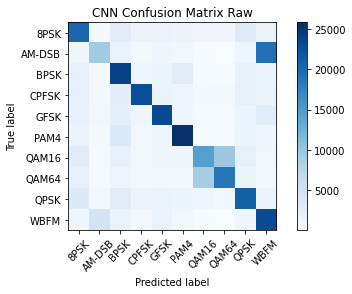

In [ ]:
y_pred = cnn_model.predict(X_test)
test_Y_all = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Raw")

acc = []
for snr in snrs:
    test_X_i = X_test[np.where(Y_test_snr == snr)]
    test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)  

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

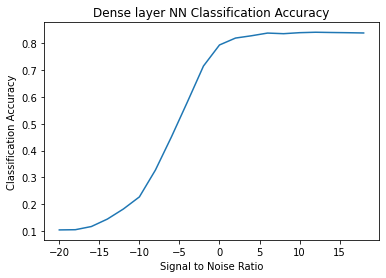

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_test[np.where(Y_test_snr == snr)]
test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

### Derivative

SNR =  -20
  Accuracy =  0.09573996006212558
SNR =  -18
  Accuracy =  0.09788256327169116
SNR =  -16
  Accuracy =  0.10045431600201918
SNR =  -14
  Accuracy =  0.10479158550837553
SNR =  -12
  Accuracy =  0.11832959334464452
SNR =  -10
  Accuracy =  0.14591580708112628
SNR =  -8
  Accuracy =  0.1851546618317675
SNR =  -6
  Accuracy =  0.22468547359086627
SNR =  -4
  Accuracy =  0.28780379289249763
SNR =  -2
  Accuracy =  0.41349977905435265
SNR =  0
  Accuracy =  0.5144859555212185
SNR =  2
  Accuracy =  0.6093126385809312
SNR =  4
  Accuracy =  0.646858038162386
SNR =  6
  Accuracy =  0.6515421445273355
SNR =  8
  Accuracy =  0.6582827889377331
SNR =  10
  Accuracy =  0.661162045730697
SNR =  12
  Accuracy =  0.6534598523944287
SNR =  14
  Accuracy =  0.6532962447844228
SNR =  16
  Accuracy =  0.651858060910869
SNR =  18
  Accuracy =  0.6590730115873552


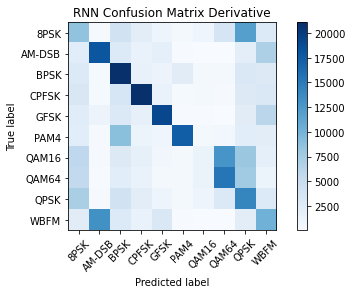

In [ ]:
y_pred = cnn_model.predict(X_deriv_test)
test_Y_all = np.argmax(Y_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Derivative")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_deriv_test[np.where(Y_deriv_test_snr == snr)]
    test_Y_i = Y_deriv_test[np.where(Y_deriv_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

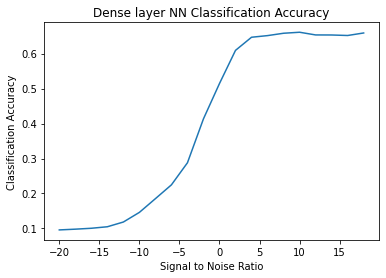

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

SNR =  0
  Accuracy =  0.5144859555212185


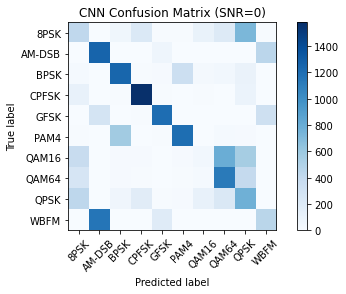

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_deriv_test[np.where(Y_deriv_test_snr == snr)]
test_Y_i = Y_deriv_test[np.where(Y_deriv_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

### Integral

SNR =  -20
  Accuracy =  0.10317284224539605
SNR =  -18
  Accuracy =  0.10883289569249678
SNR =  -16
  Accuracy =  0.11397161927197264
SNR =  -14
  Accuracy =  0.12955645834492738
SNR =  -12
  Accuracy =  0.17727546384981666
SNR =  -10
  Accuracy =  0.27125731809311404
SNR =  -8
  Accuracy =  0.37662765782099883
SNR =  -6
  Accuracy =  0.4679931275286815
SNR =  -4
  Accuracy =  0.5746065291140648
SNR =  -2
  Accuracy =  0.6633893062306673
SNR =  0
  Accuracy =  0.711439766017328
SNR =  2
  Accuracy =  0.7462860310421287
SNR =  4
  Accuracy =  0.760337977729282
SNR =  6
  Accuracy =  0.7707938982295958
SNR =  8
  Accuracy =  0.7694062656502142
SNR =  10
  Accuracy =  0.7744946426598918
SNR =  12
  Accuracy =  0.7682148604405971
SNR =  14
  Accuracy =  0.7740751043115438
SNR =  16
  Accuracy =  0.7692651578653255
SNR =  18
  Accuracy =  0.7772527843401957


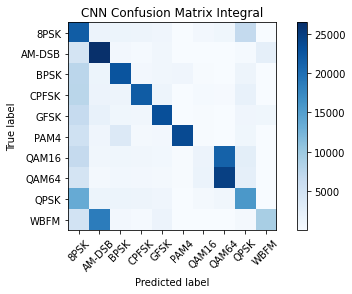

In [ ]:
y_pred = cnn_model.predict(X_int_test)
test_Y_all = np.argmax(Y_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Integral")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_int_test[np.where(Y_int_test_snr == snr)]
    test_Y_i = Y_int_test[np.where(Y_int_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

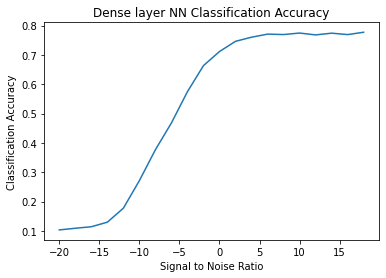

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

SNR =  0
  Accuracy =  0.711439766017328


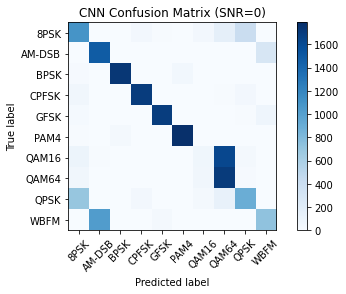

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_int_test[np.where(Y_int_test_snr == snr)]
test_Y_i = Y_int_test[np.where(Y_int_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

### Raw Derivative

SNR =  -20
  Accuracy =  0.1078877301974706
SNR =  -18
  Accuracy =  0.1030783842672775
SNR =  -16
  Accuracy =  0.11862695608278648
SNR =  -14
  Accuracy =  0.1465857866325338
SNR =  -12
  Accuracy =  0.21170160363417437
SNR =  -10
  Accuracy =  0.27242821299135767
SNR =  -8
  Accuracy =  0.3617933080599967
SNR =  -6
  Accuracy =  0.452585490217813
SNR =  -4
  Accuracy =  0.5614259496134809
SNR =  -2
  Accuracy =  0.6811754308440123
SNR =  0
  Accuracy =  0.7415153689090006
SNR =  2
  Accuracy =  0.7771618625277162
SNR =  4
  Accuracy =  0.7888198757763976
SNR =  6
  Accuracy =  0.7937868834205545
SNR =  8
  Accuracy =  0.7906070891992655
SNR =  10
  Accuracy =  0.7950403181265878
SNR =  12
  Accuracy =  0.7924088563342767
SNR =  14
  Accuracy =  0.7956606397774687
SNR =  16
  Accuracy =  0.7921765856384465
SNR =  18
  Accuracy =  0.7958713016087299


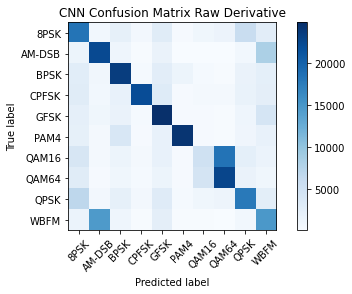

In [ ]:
y_pred = cnn_model.predict(X_raw_deriv_test)
test_Y_all = np.argmax(Y_raw_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Raw Derivative")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]
    test_Y_i = Y_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)


    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

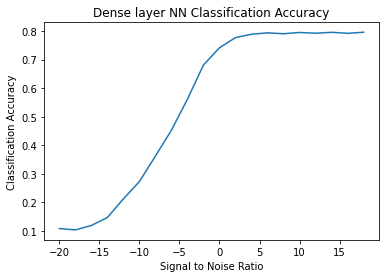

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

SNR =  0
  Accuracy =  0.7415153689090006


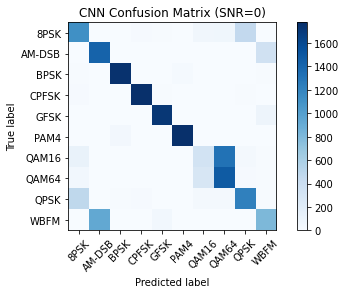

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]
test_Y_i = Y_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)


test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

### Raw Integral

SNR =  -20
  Accuracy =  0.09696028400266253
SNR =  -18
  Accuracy =  0.10704508631767137
SNR =  -16
  Accuracy =  0.11419597285321667
SNR =  -14
  Accuracy =  0.1320607713283989
SNR =  -12
  Accuracy =  0.1815992556510317
SNR =  -10
  Accuracy =  0.26439921940340116
SNR =  -8
  Accuracy =  0.3477281468051206
SNR =  -6
  Accuracy =  0.43196807626226236
SNR =  -4
  Accuracy =  0.5579222512652244
SNR =  -2
  Accuracy =  0.6687472381794078
SNR =  0
  Accuracy =  0.742674245350698
SNR =  2
  Accuracy =  0.7723946784922394
SNR =  4
  Accuracy =  0.7836718706283924
SNR =  6
  Accuracy =  0.7851018817503619
SNR =  8
  Accuracy =  0.7860998274998608
SNR =  10
  Accuracy =  0.7912294267093781
SNR =  12
  Accuracy =  0.79041118694856
SNR =  14
  Accuracy =  0.7905980528511822
SNR =  16
  Accuracy =  0.7880972338642078
SNR =  18
  Accuracy =  0.7927775902801215


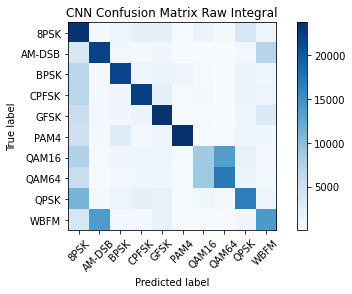

In [ ]:
y_pred = cnn_model.predict(X_raw_int_test)
test_Y_all = np.argmax(Y_raw_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Raw Integral")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_int_test[np.where(Y_raw_int_test_snr == snr)]
    test_Y_i = Y_raw_int_test[np.where(Y_raw_int_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

Text(0.5, 1.0, 'Dense layer NN Classification Accuracy')

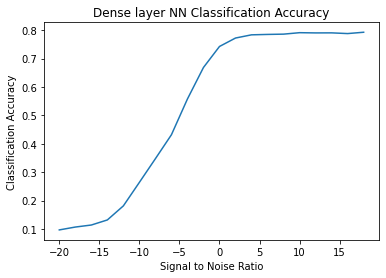

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

SNR =  0
  Accuracy =  0.742674245350698


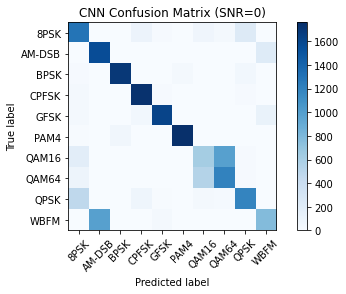

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_raw_int_test[np.where(Y_raw_int_test_snr == snr)]
test_Y_i = Y_raw_int_test[np.where(Y_raw_int_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

### Combined

In [ ]:
y_pred = cnn_model.predict(X_combined_test)
test_Y_all = np.argmax(Y_combined_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix Combined") 

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_combined_test[np.where(Y_combined_test_snr == snr)]
    test_Y_i = Y_combined_test[np.where(Y_combined_test_snr == snr)]   
    y_pred = cnn_model.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy) 

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

In [ ]:
snr = 0
print("SNR = ",snr)
test_X_i = X_combined_test[np.where(Y_combined_test_snr == snr)]
test_Y_i = Y_combined_test[np.where(Y_combined_test_snr == snr)]   
y_pred = cnn_model.predict(test_X_i, batch_size=1024)

test_Y_i = np.argmax(test_Y_i, axis=1)
y_pred = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(test_Y_i, y_pred)
acc.append(accuracy)
print("  Accuracy = ",accuracy)
conf = confusion_matrix(test_Y_i, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%d)"%(snr))

## **RNN**

Raw

In [ ]:
y_pred = rnn.predict(X_test)
test_Y_all = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Raw")

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_test[np.where(Y_test_snr == snr)]
    test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)  

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Derivative

In [ ]:
y_pred = rnn.predict(X_deriv_test)
test_Y_all = np.argmax(Y_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Derivative")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_deriv_test[np.where(Y_deriv_test_snr == snr)]
    test_Y_i = Y_deriv_test[np.where(Y_deriv_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Integral

In [ ]:
y_pred = rnn.predict(X_int_test)
test_Y_all = np.argmax(Y_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Integral")  


acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_int_test[np.where(Y_int_test_snr == snr)]
    test_Y_i = Y_int_test[np.where(Y_int_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Raw Derivative

In [ ]:
y_pred = rnn.predict(X_raw_deriv_test)
test_Y_all = np.argmax(Y_raw_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Raw Derivative")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]
    test_Y_i = Y_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Raw Integral

In [ ]:
y_pred = rnn.predict(X_raw_int_test)
test_Y_all = np.argmax(Y_raw_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Raw Integral")  


acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_int_test[np.where(Y_raw_int_test_snr == snr)]
    test_Y_i = Y_raw_int_test[np.where(Y_raw_int_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Combined

In [ ]:
y_pred = rnn.predict(X_combined_test)
test_Y_all = np.argmax(Y_combined_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="RNN Confusion Matrix Combined")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_combined_test[np.where(Y_combined_test_snr == snr)]
    test_Y_i = Y_combined_test[np.where(Y_combined_test_snr == snr)]   
    y_pred = rnn.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

## **LSTM**

Raw

In [ ]:
y_pred = lstm.predict(X_test)
test_Y_all = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Raw")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_test[np.where(Y_test_snr == snr)]
    test_Y_i = Y_test[np.where(Y_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Derivative

In [ ]:
y_pred = lstm.predict(X_deriv_test)
test_Y_all = np.argmax(Y_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Derivative") 

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_deriv_test[np.where(Y_deriv_test_snr == snr)]
    test_Y_i = Y_deriv_test[np.where(Y_deriv_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy) 

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Integral

In [ ]:
y_pred = lstm.predict(X_int_test)
test_Y_all = np.argmax(Y_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Integral")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_int_test[np.where(Y_int_test_snr == snr)]
    test_Y_i = Y_int_test[np.where(Y_int_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Raw Derivative

In [ ]:
y_pred = lstm.predict(X_raw_deriv_test)
test_Y_all = np.argmax(Y_raw_deriv_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Raw Derivative")

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]
    test_Y_i = Y_raw_deriv_test[np.where(Y_raw_deriv_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)


    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)  

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Raw Integral

In [ ]:
y_pred = lstm.predict(X_raw_int_test)
test_Y_all = np.argmax(Y_raw_int_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Raw Integral")

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_raw_int_test[np.where(Y_raw_int_test_snr == snr)]
    test_Y_i = Y_raw_int_test[np.where(Y_raw_int_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)


    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)  

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")

Combined

In [ ]:
y_pred = lstm.predict(X_combined_test)
test_Y_all = np.argmax(Y_combined_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf = confusion_matrix(test_Y_all, y_pred)
plt.figure()
plot_confusion_matrix(conf, labels=mods, title="LSTM Confusion Matrix Combined")  

acc = []
for snr in snrs:
    print("SNR = ",snr)
    test_X_i = X_combined_test[np.where(Y_combined_test_snr == snr)]
    test_Y_i = Y_combined_test[np.where(Y_combined_test_snr == snr)]   
    y_pred = lstm.predict(test_X_i, batch_size=1024)

    test_Y_i = np.argmax(test_Y_i, axis=1)
    y_pred = np.argmax(y_pred, axis=1)


    accuracy = accuracy_score(test_Y_i, y_pred)
    acc.append(accuracy)
    print("  Accuracy = ",accuracy)

In [ ]:
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Dense layer NN Classification Accuracy")